In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram

# Open simulation output.
File convention name is model_resolution_tracer_advection_scheme_downwelling_wind_amplitude


For example, the unforced case is shelf_dx_500_mpdata_uwind_0, whereas downwelling favorable winds that oscillate diurnally at a maximum amplitude of 0.001 Pa is shelf_dx_500_mpdata_uwind_001

In [2]:
path = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_0/shelf_dx_500_mpdata_uwind_0_avg.nc' #Basecase, increasing wind stress below 
path1 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_001/shelf_dx_500_mpdata_uwind_001_avg.nc'
path2 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_005/shelf_dx_500_mpdata_uwind_005_avg.nc'
path3 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_01/shelf_dx_500_mpdata_uwind_01_avg.nc'
path3_1 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_02/shelf_dx_500_mpdata_uwind_02_avg.nc'
path4 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_05/shelf_dx_500_mpdata_uwind_05_avg.nc'
path5 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_1/shelf_dx_500_mpdata_uwind_1_avg.nc'
path6 = '/d2/home/dylan/idealized_nummix/diurnal_wind/runs/shelf_dx_500_mpdata_uwind_2/shelf_dx_500_mpdata_uwind_2_avg.nc'

ds_0 = xroms.open_netcdf(path)
ds_0, grid_0 = xroms.roms_dataset(ds_0)
ds_0 = ds_0.isel(ocean_time = slice(0,264))

ds_001 = xroms.open_netcdf(path1)
ds_001, grid_001 = xroms.roms_dataset(ds_001)
ds_001 = ds_001.isel(ocean_time = slice(0,264))

ds_005 = xroms.open_netcdf(path2)
ds_005, grid_005 = xroms.roms_dataset(ds_005)
ds_005 = ds_005.isel(ocean_time = slice(0,264))

ds_01 = xroms.open_netcdf(path3)
ds_01, grid_01 = xroms.roms_dataset(ds_01)
ds_01 = ds_01.isel(ocean_time = slice(0,264))

ds_02 = xroms.open_netcdf(path3_1)
ds_02, grid_02 = xroms.roms_dataset(ds_02)
ds_02 = ds_02.isel(ocean_time = slice(0,264))

ds_05 = xroms.open_netcdf(path4)
ds_05, grid_05 = xroms.roms_dataset(ds_05)
ds_05 = ds_05.isel(ocean_time = slice(0,264))

ds_1 = xroms.open_netcdf(path5)
ds_1, grid_1 = xroms.roms_dataset(ds_1)
ds_1 = ds_1.isel(ocean_time = slice(0,264))

ds_2 = xroms.open_netcdf(path6)
ds_2, grid_2 = xroms.roms_dataset(ds_2)
ds_2 = ds_2.isel(ocean_time = slice(0,264))

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

# Plot the volume-integrated eddy kinetic energy as defined in Hetland (2017) JPO
### $u = \overline{u}+u^\prime$, where $\overline{u}= \frac{1}{L} \int_0^L u \, dx$ is the alongshore mean.
### $EKE = \frac{1}{2}(u^{\prime^2}+v^2) \xrightarrow{} \iiint_V EKE \, dV = \iiint_V \frac{1}{2}(u^{\prime^2}+v^2) \, dV$

In [4]:
etaslice = slice(1,51)
xislice = slice(1,-1)

def eke_vintegrated(ds,grid,xislice,etaslice):
    '''
Calculates volume-integrated eddy kinetic energy
    '''
    u = xroms.to_rho(ds.u, grid)
    u = u.isel(eta_rho = etaslice, xi_rho = xislice)
    v = xroms.to_rho(ds.v, grid)
    v = v.isel(eta_rho = etaslice, xi_rho = xislice)
    ubar = u.mean('xi_rho')
    uprime = u-ubar
    vprime = v
    
    eke = 0.5*(uprime**2 + vprime**2)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    eke_int = (eke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
    return eke_int
eke_int_0 = eke_vintegrated(ds_0,grid_0,xislice,etaslice)
eke_int_001 = eke_vintegrated(ds_001,grid_001,xislice,etaslice)
eke_int_005 = eke_vintegrated(ds_005,grid_005,xislice,etaslice)
eke_int_01 = eke_vintegrated(ds_01,grid_01,xislice,etaslice)
eke_int_02 = eke_vintegrated(ds_02,grid_02,xislice,etaslice)
eke_int_05 = eke_vintegrated(ds_05,grid_05,xislice,etaslice)
eke_int_1 = eke_vintegrated(ds_1,grid_1,xislice,etaslice)
eke_int_2 = eke_vintegrated(ds_2,grid_2,xislice,etaslice)

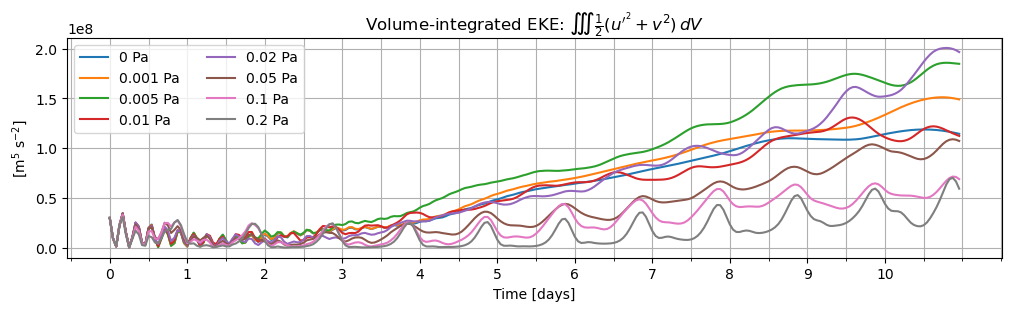

In [5]:
time = np.arange(0,264)/24 #Crude time vector, could do this a fancier way but meh. 
fig, ax = plt.subplots(1, figsize = (10,3), constrained_layout = True)

plt.plot(time, eke_int_0, label = r'0 Pa')
plt.plot(time, eke_int_001, label = r'0.001 Pa')
plt.plot(time, eke_int_005, label = r'0.005 Pa')
plt.plot(time, eke_int_01, label = r'0.01 Pa')
plt.plot(time, eke_int_02, label = r'0.02 Pa')
plt.plot(time, eke_int_05, label = r'0.05 Pa')
plt.plot(time, eke_int_1, label = r'0.1 Pa')
plt.plot(time, eke_int_2, label = r'0.2 Pa')

plt.grid(which = 'both')
plt.legend(ncol = 2)
plt.title(r'Volume-integrated EKE: $\iiint \frac{1}{2}(u^{\prime^2}+v^2) \, dV$')
plt.xlabel('Time [days]')
plt.ylabel('[m$^5$ s$^{-2}$]')
plt.xticks(np.arange(0,11))
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)

# Calculate the volume-integrated physical and numerical mixing over a control volume spanning the plume, i.e., the first 50 km in the cross-shelf direction 

In [6]:
etaslice = slice(10,51)
xislice = slice(1,-1)

def compute_mix(ds, grid):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
    '''
    mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice, ocean_time = slice(144,-1))
    mphy = ds.AKr.isel(eta_rho = etaslice, xi_rho = xislice, ocean_time = slice(144,-1))
    #Interpolate to the s-rho points 
    mphy = grid.interp(mphy, 'Z')
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice, ocean_time = slice(144,-1))
    #Load in data for quick plotting
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
    return mnum_int, mphy_int

# def compute_mix(ds, grid):
#     '''
# Computes volume-integrated physical and numerical mixing for ROMS model output.
#     '''
#     mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice)
#     mphy = ds.AKr.isel(eta_rho = etaslice, xi_rho = xislice)
#     #Interpolate to the s-rho points 
#     mphy = grid.interp(mphy, 'Z')
#     dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
#     #Load in data for quick plotting
#     mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
#     mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
#     return mnum_int, mphy_int

In [15]:
#Run the function for each simulation 
mnum_int_0, mphy_int_0 = compute_mix(ds_0,grid_0)
mnum_int_001, mphy_int_001 = compute_mix(ds_001,grid_001)
mnum_int_005, mphy_int_005 = compute_mix(ds_005,grid_005)
mnum_int_01, mphy_int_01 = compute_mix(ds_01,grid_01)
mnum_int_02, mphy_int_02 = compute_mix(ds_02,grid_02)
mnum_int_05, mphy_int_05 = compute_mix(ds_05,grid_05)
mnum_int_1, mphy_int_1 = compute_mix(ds_1,grid_1)
mnum_int_2, mphy_int_2 = compute_mix(ds_2,grid_2)

# Plot the results in linear space, then in log space 

In [26]:
# time = np.arange(0,264)/24 #Crude time vector, could do this a fancier way but meh. 
time = np.arange(144,263)/24

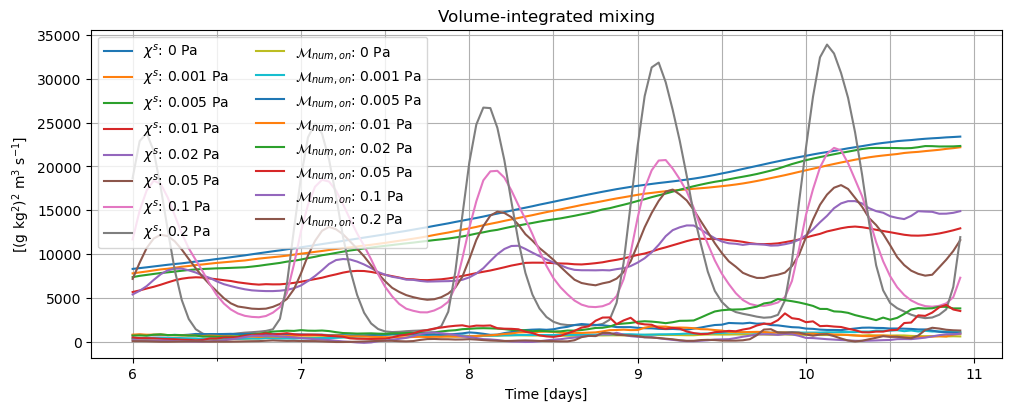

In [27]:

fig, ax = plt.subplots(1, figsize = (10,4), constrained_layout = True)

plt.plot(time, mphy_int_0, label = r'$\chi^s$: 0 Pa')
plt.plot(time, mphy_int_001, label = r'$\chi^s$: 0.001 Pa')
plt.plot(time, mphy_int_005, label = r'$\chi^s$: 0.005 Pa')
plt.plot(time, mphy_int_01, label = r'$\chi^s$: 0.01 Pa')
plt.plot(time, mphy_int_02, label = r'$\chi^s$: 0.02 Pa')
plt.plot(time, mphy_int_05, label = r'$\chi^s$: 0.05 Pa')
plt.plot(time, mphy_int_1, label = r'$\chi^s$: 0.1 Pa')
plt.plot(time, mphy_int_2, label = r'$\chi^s$: 0.2 Pa')

plt.plot(time, mnum_int_0, label = r'$\mathcal{M}_{num,on}$: 0 Pa')
plt.plot(time, mnum_int_001, label = r'$\mathcal{M}_{num,on}$: 0.001 Pa')
plt.plot(time, mnum_int_005, label = r'$\mathcal{M}_{num,on}$: 0.005 Pa')
plt.plot(time, mnum_int_01, label = r'$\mathcal{M}_{num,on}$: 0.01 Pa')
plt.plot(time, mnum_int_02, label = r'$\mathcal{M}_{num,on}$: 0.02 Pa')
plt.plot(time, mnum_int_05, label = r'$\mathcal{M}_{num,on}$: 0.05 Pa')
plt.plot(time, mnum_int_1, label = r'$\mathcal{M}_{num,on}$: 0.1 Pa')
plt.plot(time, mnum_int_2, label = r'$\mathcal{M}_{num,on}$: 0.2 Pa')

plt.grid(which = 'both')
plt.legend(ncol = 2)
plt.title('Volume-integrated mixing')
plt.xlabel('Time [days]')
plt.ylabel('[(g kg$^2$)$^2$ m$^3$ s$^{-1}$]')
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)

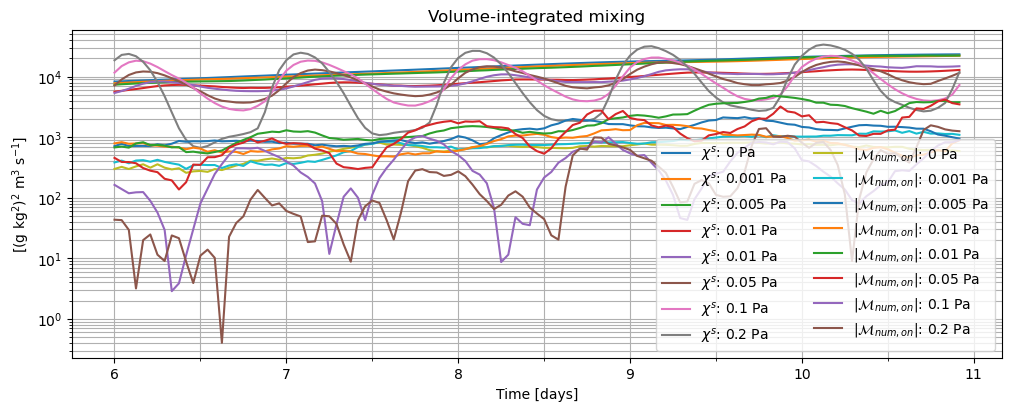

In [28]:
fig, ax = plt.subplots(1, figsize = (10,4), constrained_layout = True)

plt.semilogy(time, np.abs(mphy_int_0), label = r'$\chi^s$: 0 Pa')
plt.semilogy(time, np.abs(mphy_int_001), label = r'$\chi^s$: 0.001 Pa')
plt.semilogy(time, np.abs(mphy_int_005), label = r'$\chi^s$: 0.005 Pa')
plt.semilogy(time, np.abs(mphy_int_01), label = r'$\chi^s$: 0.01 Pa')
plt.semilogy(time, np.abs(mphy_int_02), label = r'$\chi^s$: 0.01 Pa')
plt.semilogy(time, np.abs(mphy_int_05), label = r'$\chi^s$: 0.05 Pa')
plt.semilogy(time, np.abs(mphy_int_1), label = r'$\chi^s$: 0.1 Pa')
plt.semilogy(time, np.abs(mphy_int_2), label = r'$\chi^s$: 0.2 Pa')

plt.semilogy(time, np.abs(mnum_int_0), label = r'$|\mathcal{M}_{num,on}|$: 0 Pa')
plt.semilogy(time, np.abs(mnum_int_001), label = r'$|\mathcal{M}_{num,on}|$: 0.001 Pa')
plt.semilogy(time, np.abs(mnum_int_005), label = r'$|\mathcal{M}_{num,on}|$: 0.005 Pa')
plt.semilogy(time, np.abs(mnum_int_01), label = r'$|\mathcal{M}_{num,on}|$: 0.01 Pa')
plt.semilogy(time, np.abs(mnum_int_02), label = r'$|\mathcal{M}_{num,on}|$: 0.01 Pa')
plt.semilogy(time, np.abs(mnum_int_05), label = r'$|\mathcal{M}_{num,on}|$: 0.05 Pa')
plt.semilogy(time, np.abs(mnum_int_1), label = r'$|\mathcal{M}_{num,on}|$: 0.1 Pa')
plt.semilogy(time, np.abs(mnum_int_2), label = r'$|\mathcal{M}_{num,on}|$: 0.2 Pa')

plt.grid(which = 'both')
plt.legend(ncol = 2)
plt.title('Volume-integrated mixing')
plt.xlabel('Time [days]')
plt.ylabel('[(g kg$^2$)$^2$ m$^3$ s$^{-1}$]')
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)

# Since the plots are very cluttered, let's break them up and put the resolved mixing on one subplot and numerical mixing on another  

Text(0.5, 1.0, 'Volume-integrated $\\mathcal{M}_{num,on}$')

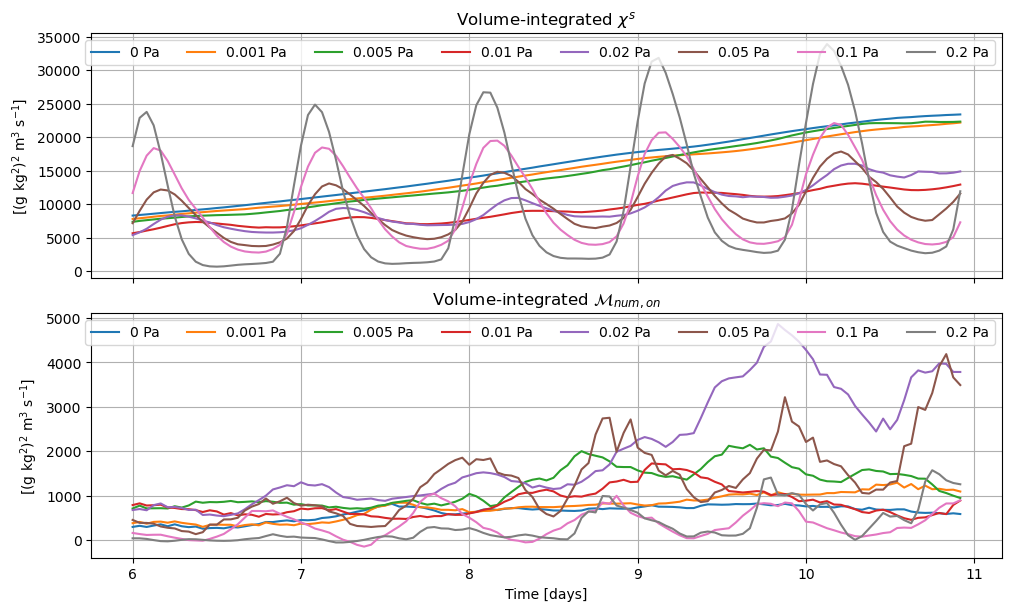

In [31]:
# time = np.arange(0,240)/24 #Crude time vector, could do this a fancier way but meh. 
fig, ax = plt.subplots(2, figsize = (10,6), constrained_layout = True)

ax[0].plot(time, mphy_int_0, label = r'0 Pa')
ax[0].plot(time, mphy_int_001, label = r'0.001 Pa')
ax[0].plot(time, mphy_int_005, label = r'0.005 Pa')
ax[0].plot(time, mphy_int_01, label = r'0.01 Pa')
ax[0].plot(time, mphy_int_02, label = r'0.02 Pa')
ax[0].plot(time, mphy_int_05, label = r'0.05 Pa')
ax[0].plot(time, mphy_int_1, label = r'0.1 Pa')
ax[0].plot(time, mphy_int_2, label = r'0.2 Pa')

plt.plot(time, mnum_int_0, label = r'0 Pa')
plt.plot(time, mnum_int_001, label = r'0.001 Pa')
plt.plot(time, mnum_int_005, label = r'0.005 Pa')
plt.plot(time, mnum_int_01, label = r'0.01 Pa')
plt.plot(time, mnum_int_02, label = r'0.02 Pa')
plt.plot(time, mnum_int_05, label = r'0.05 Pa')
plt.plot(time, mnum_int_1, label = r'0.1 Pa')
plt.plot(time, mnum_int_2, label = r'0.2 Pa')
for i in range(2):
    ax[i].grid(which = 'both')
    ax[i].legend(ncol = 8)
    ax[i].set_xlabel('Time [days]')
    ax[i].set_ylabel('[(g kg$^2$)$^2$ m$^3$ s$^{-1}$]')
    # ax[i].set_xticks(np.arange(0,12))
# minor_locator = AutoMinorLocator(2)
# ax[0].xaxis.set_minor_locator(minor_locator)
# ax[1].xaxis.set_minor_locator(minor_locator)
ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].set_title('Volume-integrated $\chi^s$')
ax[1].set_title('Volume-integrated $\mathcal{M}_{num,on}$')

Text(0.5, 1.0, 'Volume-integrated $\\mathcal{M}_{num,on}$')

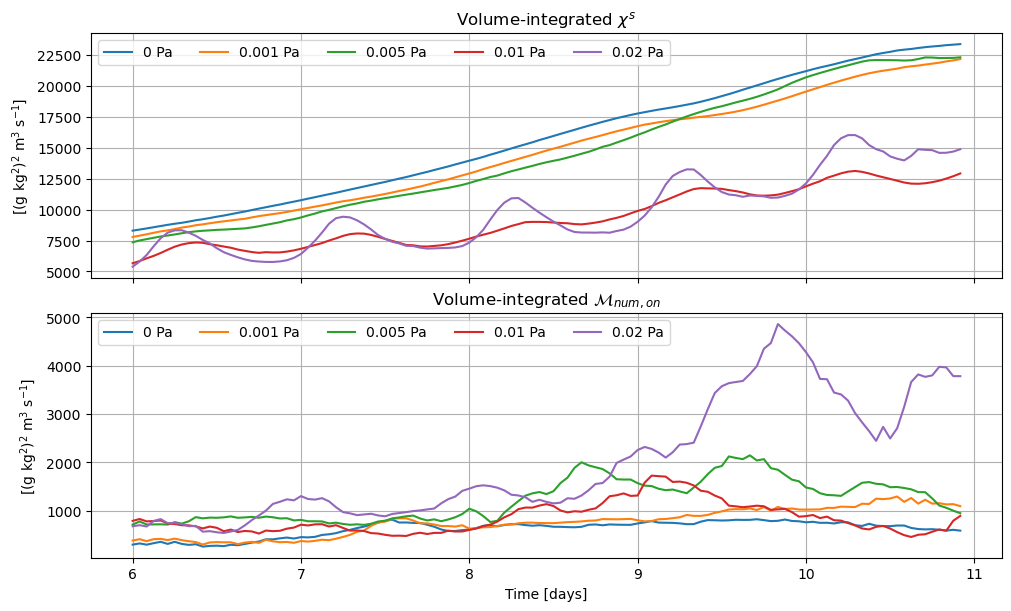

In [33]:
# time = np.arange(0,240)/24 #Crude time vector, could do this a fancier way but meh. 
fig, ax = plt.subplots(2, figsize = (10,6), constrained_layout = True)

ax[0].plot(time, mphy_int_0, label = r'0 Pa')
ax[0].plot(time, mphy_int_001, label = r'0.001 Pa')
ax[0].plot(time, mphy_int_005, label = r'0.005 Pa')
ax[0].plot(time, mphy_int_01, label = r'0.01 Pa')
ax[0].plot(time, mphy_int_02, label = r'0.02 Pa')

plt.plot(time, mnum_int_0, label = r'0 Pa')
plt.plot(time, mnum_int_001, label = r'0.001 Pa')
plt.plot(time, mnum_int_005, label = r'0.005 Pa')
plt.plot(time, mnum_int_01, label = r'0.01 Pa')
plt.plot(time, mnum_int_02, label = r'0.02 Pa')
for i in range(2):
    ax[i].grid(which = 'both')
    ax[i].legend(ncol = 8)
    ax[i].set_xlabel('Time [days]')
    ax[i].set_ylabel('[(g kg$^2$)$^2$ m$^3$ s$^{-1}$]')
    # ax[i].set_xticks(np.arange(0,12))
# minor_locator = AutoMinorLocator(2)
# ax[0].xaxis.set_minor_locator(minor_locator)
# ax[1].xaxis.set_minor_locator(minor_locator)
ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].set_title('Volume-integrated $\chi^s$')
ax[1].set_title('Volume-integrated $\mathcal{M}_{num,on}$')

Text(0.5, 1.0, 'Volume-integrated $\\mathcal{M}_{num,on}$')

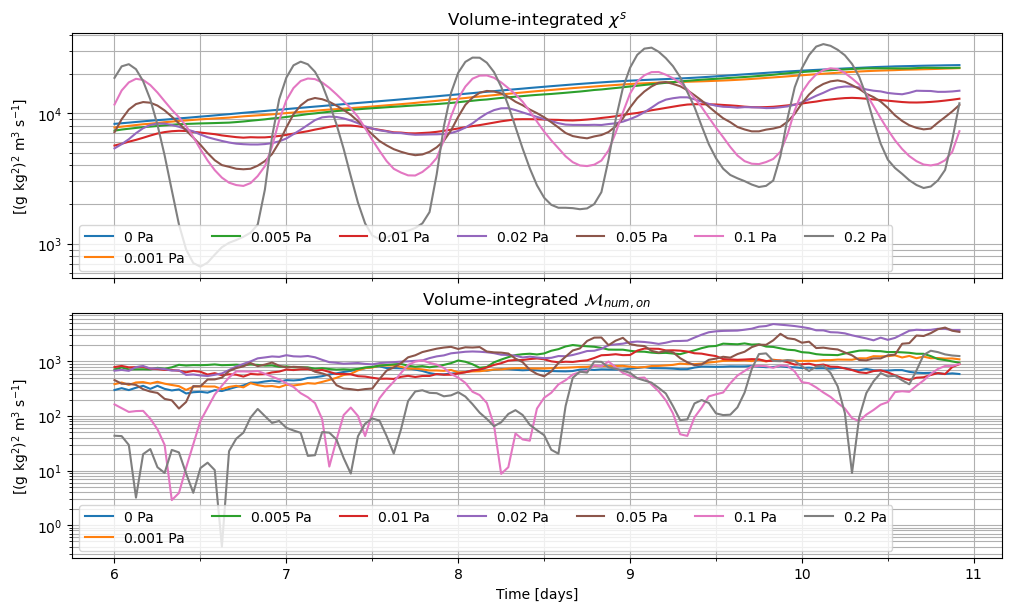

In [34]:
# time = np.arange(0,240)/24 #Crude time vector, could do this a fancier way but meh. 
fig, ax = plt.subplots(2, figsize = (10,6), constrained_layout = True)

ax[0].semilogy(time, mphy_int_0, label = r'0 Pa')
ax[0].semilogy(time, mphy_int_001, label = r'0.001 Pa')
ax[0].semilogy(time, mphy_int_005, label = r'0.005 Pa')
ax[0].semilogy(time, mphy_int_01, label = r'0.01 Pa')
ax[0].semilogy(time, mphy_int_02, label = r'0.02 Pa')
ax[0].semilogy(time, mphy_int_05, label = r'0.05 Pa')
ax[0].semilogy(time, mphy_int_1, label = r'0.1 Pa')
ax[0].semilogy(time, mphy_int_2, label = r'0.2 Pa')

plt.semilogy(time, np.abs(mnum_int_0), label = r'0 Pa')
plt.semilogy(time, np.abs(mnum_int_001), label = r'0.001 Pa')
plt.semilogy(time, np.abs(mnum_int_005), label = r'0.005 Pa')
plt.semilogy(time, np.abs(mnum_int_01), label = r'0.01 Pa')
plt.semilogy(time, np.abs(mnum_int_02), label = r'0.02 Pa')
plt.semilogy(time, np.abs(mnum_int_05), label = r'0.05 Pa')
plt.semilogy(time, np.abs(mnum_int_1), label = r'0.1 Pa')
plt.semilogy(time, np.abs(mnum_int_2), label = r'0.2 Pa')
for i in range(2):
    ax[i].grid(which = 'both')
    ax[i].legend(ncol = 7)
    ax[i].set_xlabel('Time [days]')
    ax[i].set_ylabel('[(g kg$^2$)$^2$ m$^3$ s$^{-1}$]')
minor_locator = AutoMinorLocator(2)
ax[0].xaxis.set_minor_locator(minor_locator)
ax[1].xaxis.set_minor_locator(minor_locator)
ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].set_title('Volume-integrated $\chi^s$')
ax[1].set_title('Volume-integrated $\mathcal{M}_{num,on}$')

# Compute the ratio of bulk volume-integrated numerical to physical mixing for each run 

In [35]:
print(mnum_int_0.sum().values/(mphy_int_0.sum().values))
print(mnum_int_001.sum().values/(mphy_int_001.sum().values))
print(mnum_int_005.sum().values/(mphy_int_005.sum().values))
print(mnum_int_01.sum().values/(mphy_int_01.sum().values))
print(mnum_int_02.sum().values/(mphy_int_02.sum().values))
print(mnum_int_05.sum().values/(mphy_int_05.sum().values))
print(mnum_int_1.sum().values/(mphy_int_1.sum().values))
print(mnum_int_2.sum().values/(mphy_int_2.sum().values))

0.0395282132729982
0.05169202648891854
0.08410248296734081
0.09144540867311417
0.20281985722924994
0.138379938980383
0.0357274620166094
0.03130516232509355


# Make a summary scatterplot that shows the ratio 

In [16]:
r1=mnum_int_0.sum().values/(mphy_int_0.sum().values)
r2=mnum_int_001.sum().values/(mphy_int_001.sum().values)
r3=mnum_int_005.sum().values/(mphy_int_005.sum().values)
r4=mnum_int_01.sum().values/(mphy_int_01.sum().values)
r5=mnum_int_02.sum().values/(mphy_int_02.sum().values)
r6=mnum_int_05.sum().values/(mphy_int_05.sum().values)
r7=mnum_int_1.sum().values/(mphy_int_1.sum().values)
r8=mnum_int_2.sum().values/(mphy_int_2.sum().values)

r11=mnum_int_0.sum().values
r22=mnum_int_001.sum().values
r33=mnum_int_005.sum().values
r44=mnum_int_01.sum().values
r55=mnum_int_02.sum().values
r66=mnum_int_05.sum().values
r77=mnum_int_1.sum().values
r88=mnum_int_2.sum().values

r111=mphy_int_0.sum().values
r222=mphy_int_001.sum().values
r333=mphy_int_005.sum().values
r444=mphy_int_01.sum().values
r555=mphy_int_02.sum().values
r666=mphy_int_05.sum().values
r777=mphy_int_1.sum().values
r888=mphy_int_2.sum().values

rx = [0, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
ry = [r1,r2,r3,r4,r5,r6,r7,r8]
ryy = [r11,r22,r33,r44,r55,r66,r77,r88]
ryyy = [r111,r222,r333,r444,r555,r666,r777,r888]

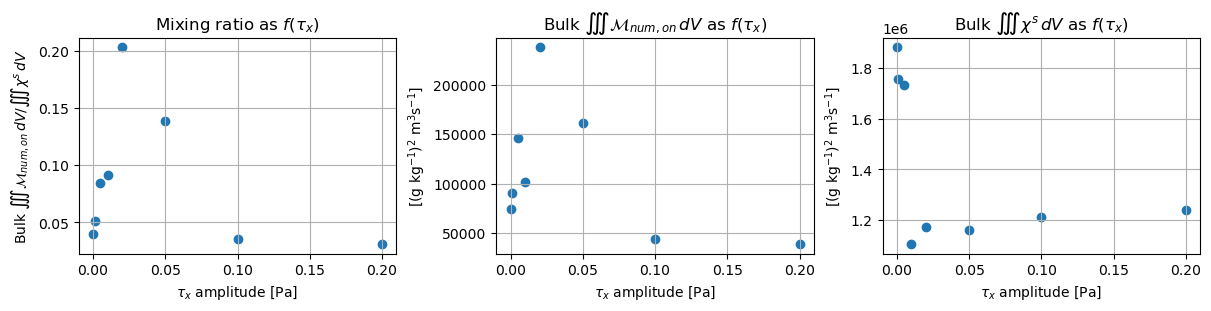

In [53]:
fig, ax = plt.subplots(1,3, figsize = (12,3), constrained_layout = True)

ax[0].scatter(rx,ry)
ax[0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[0].set_ylabel('Bulk $\iiint \mathcal{M}_{num,on} \, dV / \iiint \chi^s \, dV$')
ax[0].set_title(r'Mixing ratio as $f(\tau_x)$')
ax[0].grid(which = 'both')

ax[1].scatter(rx,ryy)
ax[1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[1].set_title(r'Bulk $\iiint \mathcal{M}_{num,on} \, dV$ as $f(\tau_x)$')
ax[1].grid(which = 'both')

ax[2].scatter(rx,ryyy)
ax[2].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[2].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[2].set_title(r'Bulk $\iiint \chi^s \, dV$ as $f(\tau_x)$')
ax[2].grid(which = 'both')
# for i in range(3):
    # ax[i].set_xscale('log')
# plt.savefig('mixing_function_taux')

The numerical and physical mixing change differently as a function of wind stress. Numerical mixing decreases up to 0.02 Pa then drops off. Physical mixing on the other hand is largest for the base case, gradually decreases for very small wind stress, then massively drops off and gradually increases. 

# Examine histograms of salinity gradient magnitude, both horizontal and vertical. I suspect this will be highly correlated with the above plots 

In [7]:
def sgradmag_h_hist(ds, grid, etaslice, xislice):
    '''
Computes the horz. salinity gradient magnitude for the entire
water column on the psi points.
    ''' 
    dsaltdxi, dsaltdeta = xroms.hgrad(ds.salt, grid)
    dsaltdxi_rho = xroms.to_rho(dsaltdxi, grid)
    dsaltdeta_rho = xroms.to_rho(dsaltdeta, grid)
    sgradmag = (dsaltdxi_rho**2+dsaltdeta_rho**2)**(1/2)
    sgradmag_srho = grid.interp(sgradmag, 'Z', boundary = 'extend')
    sgradmag_srho.attrs = ''
    sgradmag_srho.name = 'sgradmag'
    
    sgradbins = np.linspace(0,0.002,150)
    sgradmag_rho_hist = histogram(sgradmag_srho.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice), 
                                  bins = [sgradbins], density = True).load()
    sgradmag_rho_hist.name = 'sgradmag'
    return sgradmag_rho_hist, sgradmag_srho

def sgradmag_v_hist(ds, grid, etaslice, xislice):
    '''
Computes the vertical salinity gradient magnitude for the entire
water column on the psi points.
    ''' 
    dsdz = xroms.ddz(ds.salt, grid)
    dsdz_srho = grid.interp(dsdz, 'Z', boundary = 'extend')
    dsdz_srho.attrs = ''
    dsdz_srho.name = 'dsdz'
    
    sgradbins = np.linspace(0,0.02,150)
    dsdz_hist = histogram(dsdz.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice), 
                                  bins = [sgradbins], density = True).load()
    dsdz_hist.name = 'sgradmag'
    return dsdz_hist, dsdz_srho

In [8]:
sgradmag_rho_hist_0, sgradmag_srho_0 = sgradmag_h_hist(ds_0, grid_0, etaslice, xislice)
sgradmag_rho_hist_001, sgradmag_srho_001  = sgradmag_h_hist(ds_001, grid_001, etaslice, xislice)
sgradmag_rho_hist_005, sgradmag_srho_005  = sgradmag_h_hist(ds_005, grid_005, etaslice, xislice)
sgradmag_rho_hist_01, sgradmag_srho_01  = sgradmag_h_hist(ds_01, grid_01, etaslice, xislice)
sgradmag_rho_hist_02, sgradmag_srho_02  = sgradmag_h_hist(ds_02, grid_02, etaslice, xislice)
sgradmag_rho_hist_05, sgradmag_srho_05  = sgradmag_h_hist(ds_05, grid_05, etaslice, xislice)
sgradmag_rho_hist_1, sgradmag_srho_1  = sgradmag_h_hist(ds_1, grid_1, etaslice, xislice)
sgradmag_rho_hist_2, sgradmag_srho_2  = sgradmag_h_hist(ds_2, grid_2, etaslice, xislice)

dsdz_hist_0, dsdz_0 = sgradmag_v_hist(ds_0, grid_0, etaslice, xislice)
dsdz_hist_001, dsdz_001  = sgradmag_v_hist(ds_001, grid_001, etaslice, xislice)
dsdz_hist_005, dsdz_005  = sgradmag_v_hist(ds_005, grid_005, etaslice, xislice)
dsdz_hist_01, dsdz_01  = sgradmag_v_hist(ds_01, grid_01, etaslice, xislice)
dsdz_hist_02, dsdz_02  = sgradmag_v_hist(ds_02, grid_02, etaslice, xislice)
dsdz_hist_05, dsdz_05  = sgradmag_v_hist(ds_05, grid_05, etaslice, xislice)
dsdz_hist_1, dsdz_1  = sgradmag_v_hist(ds_1, grid_1, etaslice, xislice)
dsdz_hist_2, dsdz_2  = sgradmag_v_hist(ds_2, grid_2, etaslice, xislice)

In [9]:
shgrad_0 = sgradmag_srho_0.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
shgrad_001 = sgradmag_srho_001.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
shgrad_005 = sgradmag_srho_005.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
shgrad_01 = sgradmag_srho_01.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
shgrad_02 = sgradmag_srho_02.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
shgrad_05 = sgradmag_srho_05.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
shgrad_1 = sgradmag_srho_1.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
shgrad_2 = sgradmag_srho_2.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values

print(shgrad_0)
print(shgrad_001)
print(shgrad_005)
print(shgrad_01)
print(shgrad_02)
print(shgrad_05)
print(shgrad_1)
print(shgrad_2)

0.0001166828383973353
0.00012179734859893611
0.00013318749246933007
0.00012734326945067
0.00013447211867766365
0.00013010139610553553
0.00013089501793932628
0.00013351549228218703


In [10]:
svgrad_0 = dsdz_0.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
svgrad_001 = dsdz_001.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
svgrad_005 = dsdz_005.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
svgrad_01 = dsdz_01.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
svgrad_02 = dsdz_02.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
svgrad_05 = dsdz_05.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
svgrad_1 = dsdz_1.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values
svgrad_2 = dsdz_2.isel(ocean_time = slice(144,-1), eta_rho = etaslice, xi_rho = xislice).mean().values

print(svgrad_0)
print(svgrad_001)
print(svgrad_005)
print(svgrad_01)
print(svgrad_02)
print(svgrad_05)
print(svgrad_1)
print(svgrad_2)

-0.04899041125411709
-0.04618699476108835
-0.04373126956534276
-0.0288682663987601
-0.01997732408924995
-0.009783972521194605
-0.005749315614460471
-0.003230780467353362


Text(0.5, 1.0, 'Horizontal Salinity Grad. Mag. ')

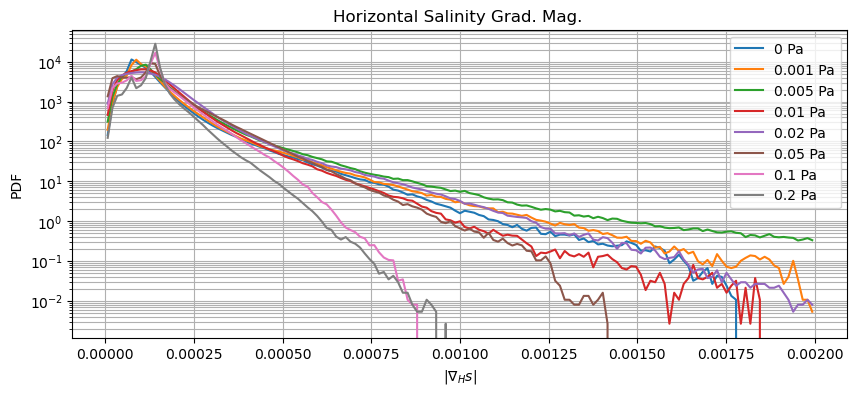

In [11]:
sbins = sgradmag_rho_hist_0.sgradmag_bin
fig, ax = plt.subplots(figsize = (10,4))

plt.semilogy(sbins, sgradmag_rho_hist_0, label = r'0 Pa')
plt.semilogy(sbins, sgradmag_rho_hist_001, label = r'0.001 Pa')
plt.semilogy(sbins, sgradmag_rho_hist_005, label = r'0.005 Pa')
plt.semilogy(sbins, sgradmag_rho_hist_01, label = r'0.01 Pa')
plt.semilogy(sbins, sgradmag_rho_hist_02, label = r'0.02 Pa')
plt.semilogy(sbins, sgradmag_rho_hist_05, label = r'0.05 Pa')
plt.semilogy(sbins, sgradmag_rho_hist_1, label = r'0.1 Pa')
plt.semilogy(sbins, sgradmag_rho_hist_2, label = r'0.2 Pa')
plt.grid(which = 'both')
plt.legend()
plt.ylabel('PDF')
plt.xlabel(r'$|\nabla_H s|$ [g/kg/m]')
plt.title('Horizontal Salinity Grad. Mag. ')

(0.0, 0.0005)

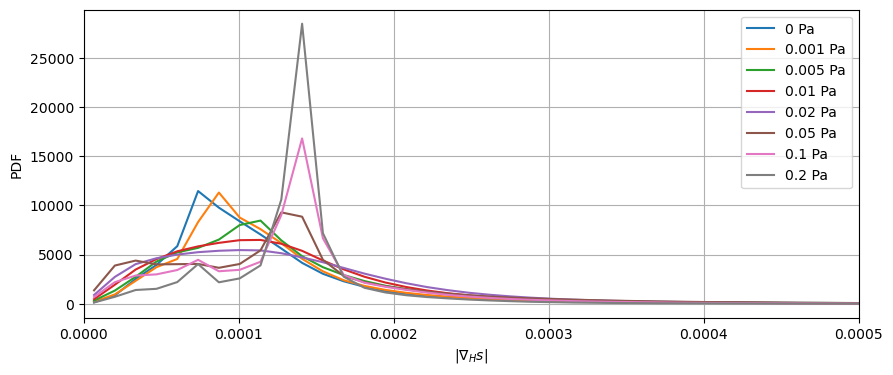

In [75]:
sbins = sgradmag_rho_hist_0.sgradmag_bin
fig, ax = plt.subplots(figsize = (10,4))

plt.plot(sbins, sgradmag_rho_hist_0, label = r'0 Pa')
plt.plot(sbins, sgradmag_rho_hist_001, label = r'0.001 Pa')
plt.plot(sbins, sgradmag_rho_hist_005, label = r'0.005 Pa')
plt.plot(sbins, sgradmag_rho_hist_01, label = r'0.01 Pa')
plt.plot(sbins, sgradmag_rho_hist_02, label = r'0.02 Pa')
plt.plot(sbins, sgradmag_rho_hist_05, label = r'0.05 Pa')
plt.plot(sbins, sgradmag_rho_hist_1, label = r'0.1 Pa')
plt.plot(sbins, sgradmag_rho_hist_2, label = r'0.2 Pa')
plt.grid(which = 'both')
plt.legend()
plt.ylabel('PDF')
plt.xlabel(r'$|\nabla_H s|$')
plt.xlim(0,0.0005)

(0.0, 0.01)

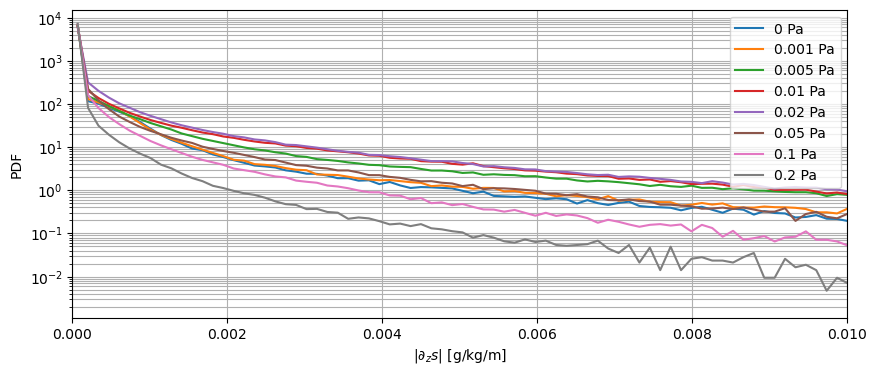

In [12]:
dsdzbins = dsdz_hist_0.dsaltdz_bin
fig, ax = plt.subplots(figsize = (10,4))

plt.semilogy(dsdzbins, dsdz_hist_0, label = r'0 Pa')
plt.semilogy(dsdzbins, dsdz_hist_001, label = r'0.001 Pa')
plt.semilogy(dsdzbins, dsdz_hist_005, label = r'0.005 Pa')
plt.semilogy(dsdzbins, dsdz_hist_01, label = r'0.01 Pa')
plt.semilogy(dsdzbins, dsdz_hist_02, label = r'0.02 Pa')
plt.semilogy(dsdzbins, dsdz_hist_05, label = r'0.05 Pa')
plt.semilogy(dsdzbins, dsdz_hist_1, label = r'0.1 Pa')
plt.semilogy(dsdzbins, dsdz_hist_2, label = r'0.2 Pa')
plt.grid(which = 'both')
plt.legend()
plt.ylabel('PDF')
plt.xlabel(r'$|\partial_z s|$ [g/kg/m]')
plt.xlim(0,0.01)

# There is a very interesting nonlinear relationship between horizontal salinity gradient magnitude and numerical mixing. Physical mixing on the other hand is linear 

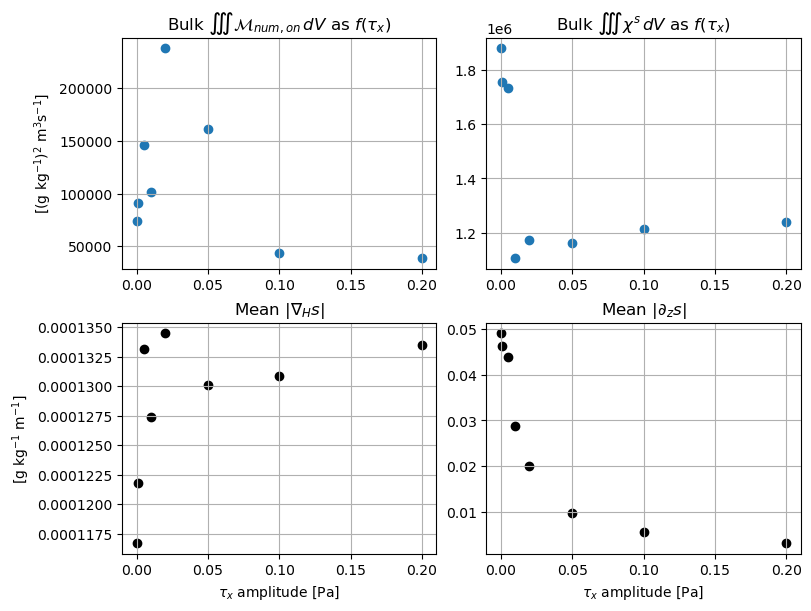

In [17]:
fig, ax = plt.subplots(2,2, figsize = (8,6), constrained_layout = True)

ax[0,0].scatter(rx,ryy)
ax[0,0].set_xlabel(r'')
ax[0,0].set_ylabel('[(g kg$^{-1}$)$^2$ m$^3$s$^{-1}$]')
ax[0,0].set_title(r'Bulk $\iiint \mathcal{M}_{num,on} \, dV$ as $f(\tau_x)$')

test = np.array([shgrad_0, shgrad_001, shgrad_005, shgrad_01, shgrad_02, shgrad_05, shgrad_1, shgrad_2])
ax[1,0].scatter(rx, test, c = 'k')
ax[1,0].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,0].set_ylabel(r'[g kg$^{-1}$ m$^{-1}$]')

ax[0,1].scatter(rx,ryyy)
ax[0,1].set_xlabel(r'')
ax[0,1].set_ylabel(r'')
ax[0,1].set_title(r'Bulk $\iiint \chi^s \, dV$ as $f(\tau_x)$')

test1 = np.array([svgrad_0, svgrad_001, svgrad_005, svgrad_01, svgrad_02, svgrad_05, svgrad_1, svgrad_2])
ax[1,1].scatter(rx, np.abs(test1), c = 'k')
ax[1,1].set_xlabel(r'$\tau_x$ amplitude [Pa]')
ax[1,1].set_ylabel(r'')

ax[1,0].set_title(r'Mean $|\nabla_H s|$')
ax[1,1].set_title(r'Mean $|\partial_z s|$')
for i in range(2):
    for j in range(2):
        ax[i,j].grid(which = 'both')
# plt.savefig('mixing_function_taux')

# To summarize so far, there the average vertical salinity decreases exponentially as a function of along-shelf wind stress for a periodic downwelling configuration. Horizontal salinity gradient is much more complicated and likewise for numerical mixing. 
The gradual increase in numerical mixing for larger wind stress could be because of changes to the eddy diffusivty, which will absolutely be modifed by the energy added from the winds. 

In [51]:
# rymax_phy = [mphy_int_0.max().values,mphy_int_001.max().values,mphy_int_005.max().values,
#               mphy_int_01.max().values,mphy_int_02.max().values, mphy_int_05.max().values,mphy_int_1.max().values,
#              mphy_int_2.max().values]

# rymax_num = [mnum_int_0.max().values,mnum_int_001.max().values,mnum_int_005.max().values,
#              mnum_int_01.max().values, mnum_int_02.max().values, mnum_int_05.max().values,mnum_int_1.max().values,
#              mnum_int_2.max().values]

In [52]:
# fig, ax = plt.subplots(1, figsize = (4,4))

# plt.scatter(rx,rymax_phy)
# plt.scatter(rx,rymax_num)
# plt.xlabel('Along-shelf wind stress amplitude [Pa]')
# plt.ylabel('Bulk $\iiint \chi^s \, dV / \iiint \mathcal{M}_{num,on} \, dV$')
# plt.title(r'Mixing as $f(\tau_x)$')